In [11]:
# General imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Feature selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

# Classification metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew, kurtosis

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vectorbt as vbt
import redshift_connector


In [2]:
class OrderBookSnapshot:
    
    def __init__(self, order_book_df):
        order_book_df['bids'] = ('[' + order_book_df['bids'] + ']').str.replace('}', '},').replace('},]', '}]')
        order_book_df['asks'] = ('[' + order_book_df['asks'] + ']').str.replace('}', '},').replace('},]', '}]')

    def bid_ask_spread():
        highest_bid = self.parse_order_book(self.order_book_df.iloc[0], 'bids')['price'].max()
        lowest_ask = self.parse_order_book(self.order_book_df.iloc[0], 'asks')['price'].min()
        return lowest_ask - highest_bid


In [3]:
def calculate_triple_barrier_labels(ohlcv_df, atr_window, max_holding_time):
    # Calculate ATR using vectorbt
    high = ohlcv_df['price_high']
    low = ohlcv_df['price_low']
    close = ohlcv_df['price_close']

    atr = vbt.ATR.run(high, low, close, window=atr_window).atr

    # Initialize labels array with zeros
    labels = np.zeros(len(close))

    # Loop through the close price series
    for i in range(len(close) - max_holding_time):
        # Set the upper and lower barriers
        upper_barrier = close[i] + atr[i]
        lower_barrier = close[i] - atr[i]
        barrier_hit = False

        # Check if price hits the barriers within the max holding time
        for j in range(i + 1, i + max_holding_time + 1):
            # Ensure the loop does not go beyond the length of the series
            if j >= len(close):
                break

            if high[j] >= upper_barrier:
                labels[i] = 1  # Upper barrier hit
                barrier_hit = True
                break
            elif low[j] <= lower_barrier:
                labels[i] = -1  # Lower barrier hit
                barrier_hit = True
                break

        # If no barriers are hit, determine label based on closing price after max holding time
        if not barrier_hit:
            labels[i] = 1 if close[j] > close[i] else -1

    # Create a Pandas Series from the labels array
    label_series = pd.Series(labels, index=ohlcv_df.index)

    return label_series

In [4]:
def execute_query(query, cols, date_col):
    with redshift_connector.connect(
        host = 'project-poseidon.cpsnf8brapsd.us-west-2.redshift.amazonaws.com',
        database = 'token_price',
        user = 'administrator',
        password = 'Free2play2'
    ) as conn:
        with conn.cursor() as cursor:
            # Execute query on Redshift and return result
            cursor.execute(query)
            tuples = cursor.fetchall()
            
            # Return queried data as a DataFrame
            df = pd.DataFrame(tuples, columns = cols).set_index(date_col)

            # For each column in DataFrame, convert to float, skip if not possible
            for col in df.columns:
                try:
                    df[col] = df[col].astype(float)
                except:
                    continue

            # Fill in any gaps in data with last seen value
            df = df.drop_duplicates().asfreq(freq = 'H', method = 'ffill')

            return df


In [5]:
# Custom transformers for feature engineering

class RollingMinMaxScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, window_sizes):
        self.window_sizes = window_sizes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        new_cols = []
        for col in X_copy.columns:
            if '_rz_' in col:
                continue

            for window_size in self.window_sizes:
                col_name = col + '_rmm_' + str(window_size)
                rolling_min = X_copy[col].rolling(window = window_size).min()
                rolling_max = X_copy[col].rolling(window = window_size).max()
                new_col = pd.Series((X_copy[col] - rolling_min) / (rolling_max - rolling_min), name = col_name)

                new_cols.append(new_col)
        
        X_copy = pd.concat([X_copy] + new_cols, axis = 1)
        return X_copy

class RollingZScoreScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, window_sizes):
        self.window_sizes = window_sizes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        new_cols = []

        for col in X_copy.columns:
            if '_rmm_' in col:
                continue

            for window_size in self.window_sizes:
                col_name = col + '_rz_' + str(window_size)
                rolling_mean = X_copy[col].rolling(window = window_size).mean()
                rolling_std = X_copy[col].rolling(window = window_size).std()
                new_col = pd.Series((X_copy[col] - rolling_mean) / rolling_std, name = col_name)

                new_cols.append(new_col)   

        X_copy = pd.concat([X_copy] + new_cols, axis = 1)
        
        return X_copy

class LagFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, lags):
        self.lags = lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        cols = []
        for col in X_copy.columns:
            for lag in self.lags:
                col_name = col + '_lag_' + str(lag)
                cols.append(pd.Series(X_copy[col].shift(lag), name = col_name))

        X_copy = pd.concat([X_copy] + cols, axis = 1)

        return X_copy.dropna()

class BlockFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        query = """
        SELECT *
        FROM administrator.metrics.block_metrics
        ORDER BY timestamp ASC
        """
        block_cols = [
            'timestamp', 'avg_block_size', 'block_count', 'avg_block_reward',
            'avg_difficulty', 'num_unique_miners', 'difficulty_adjustment', 
            'pct_gas_limit_used'
        ]
        
        block_data = execute_query(
            query = query,
            cols = block_cols,
            date_col = 'timestamp'
        )

        self.block_data = block_data

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        merged = pd.merge(X, self.block_data, how = 'inner', left_index = True, right_index = True)
        return merged

class TransactionFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        query = """
        SELECT *
        FROM administrator.metrics.transaction_metrics
        ORDER BY "timestamp" ASC
        """
        transaction_cols = [
            'timestamp', 'transaction_volume', 'avg_transaction_size', 'num_transactions', 
            'num_transactions_gt_1000_eth', 'num_transactions_gt_10000_eth', 'num_transactions_gt_100000_eth',
            'transaction_failure_rate', 'avg_gas_used', 'total_gas_used', 'avg_gas_price', 'avg_gas_fee',
            'total_gas_fees'
            ]
        
        transaction_data = execute_query(
            query = query,
            cols = transaction_cols,
            date_col = 'timestamp'
        )
        self.transaction_data = transaction_data

    def fit(self, X, y=None):
        return self

    def transform(self, X):    
        merged = pd.merge(X, self.transaction_data, how = 'inner', left_index = True, right_index = True)
        return merged
    
class TransferFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        query = """
        SELECT *
        FROM metrics.eth.transfer_metrics
        ORDER BY "timestamp" ASC
        """
        transfer_cols = []
        transfer_data = execute_query(
            query = query,
            cols = transfer_cols,
            date_col = 'timestamp'
        )
        self.transfer_data = transfer_data

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        merged = pd.merge(X, self.transfer_data, how = 'inner', left_index = True, right_index = True)
        return merged
  
class OrderBookFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, symbol_id):
        base, quote, exchange = symbol_id.split('_')
        query = f"""
        SELECT *
        FROM token_price.coinapi.order_book_data_1h
        WHERE
            asset_id_base = '{base}' AND
            asset_id_quote = '{quote}' AND
            exchange_id = '{exchange}'
        ORDER BY time_exchange ASC
        """
        order_book_cols = ['symbol_id', 'time_exchange', 'time_coinapi', 'asks', 'bids', 'asset_id_base', 'asset_id_quote', 'exchange_id']
        order_book_data = execute_query(
            query = query,
            cols = order_book_cols,
            date_col = 'time_exchange'
        )
        self.snapshot = OrderBookSnapshot(order_book_data)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        merged = pd.merge(X, self.transaction_data, how = 'inner', left_index = True, right_index = True)
        return merged
     
class NetworkFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        query = f"""
        SELECT *
        FROM metrics.eth.network_metrics
        ORDER BY "timestamp" ASC
        """
        network_cols = ['timestamp', 'liquidity_ratio']
        network_data = execute_query(
            query = query,
            cols = network_cols,
            date_col = 'timestamp'
        )
        self.network_data = network_data

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        merged = pd.merge(X, self.network_data, how = 'inner', left_index = True, right_index = True)
        return merged

class TickFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, symbol_id):
        base, quote, exchange = symbol_id.split('_')
        query = f"""
        SELECT
            "timestamp", 
            buy_to_sell_ratio, 
            buy_to_sell_volume_ratio, 
            avg_trade_size,
            vwap, 
            buy_trade_size_std, 
            sell_trade_size_std, 
            avg_buy_trade_size,
            avg_sell_trade_size, 
            avg_seconds_between_sell_trades, 
            avg_seconds_between_buy_trades,
            std_seconds_between_sell_trades, 
            std_seconds_between_buy_trades
        FROM token_price.metrics.tick_metrics
        WHERE
            asset_id_base = '{base}' AND
            asset_id_quote = '{quote}' AND
            exchange_id = '{exchange}'
        ORDER BY timestamp ASC
        """
        tick_cols = [
            'timestamp', 'buy_to_sell_ratio', 'buy_to_sell_volume_ratio', 'avg_trade_size',
            'vwap', 'buy_trade_size_std', 'sell_trade_size_std', 'avg_buy_trade_size',
            'avg_sell_trade_size', 'avg_seconds_between_sell_trades', 'avg_seconds_between_buy_trades',
            'std_seconds_between_sell_trades', 'std_seconds_between_buy_trades'
        ]
        tick_data = execute_query(
            query = query,
            cols = tick_cols,
            date_col = 'timestamp'
        )
        self.tick_data = tick_data

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        merged = pd.merge(X, self.tick_data, how = 'inner', left_index = True, right_index = True)
        return merged
    
class WalletFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pass
    
class PriceFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, symbol_id):
        self.symbol_id = symbol_id

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pass

class TimeFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Extract various time-based features from datetime index
        X_copy = X.copy()
        X_copy['hour'] = X_copy.index.hour        
        X_copy['day'] = X_copy.index.day
        X_copy['month'] = X_copy.index.month
        X_copy['week'] = X_copy.index.isocalendar().week
        X_copy['quarter'] = X_copy.index.quarter
        X_copy['year'] = X_copy.index.year
        X_copy['is_month_start'] = X_copy.index.is_month_start
        X_copy['is_month_end'] = X_copy.index.is_month_end
        X_copy['is_quarter_start'] = X_copy.index.is_quarter_start
        X_copy['is_quarter_end'] = X_copy.index.is_quarter_end
        X_copy['is_year_start'] = X_copy.index.is_year_start
        X_copy['is_year_end'] = X_copy.index.is_year_end
        X_copy['is_leap_year'] = X_copy.index.is_leap_year

        return X_copy

class DropColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        # cols_to_drop = [col for col in X.columns if not ('_rmm_' in col or '_rz_' in col)]
        # X_copy = X_copy.drop(columns = cols_to_drop, axis = 1)

        # Fill nan values for each column with the rolling mean of that column
        for col in X_copy.columns:
            try:
                X_copy[col] = X_copy[col].fillna(X_copy[col].rolling(window = 24).mean().fillna(0))
            except:
                continue

        return X_copy

In [6]:
symbol_id = 'BTC_USD_COINBASE'
base, quote, exchange = symbol_id.split('_')

query = """
SELECT
    time_period_end,
    price_open,
    price_high,
    price_low,
    price_close,
    volume_traded
FROM token_price.coinapi.price_data_1h
WHERE 
    asset_id_base = '{}' AND
    asset_id_quote = '{}' AND
    exchange_id = '{}'
ORDER BY time_period_start ASC
""".format(base, quote, exchange)

In [7]:
# Specify window sizes for rolling min-max and z-score scaling
window_sizes = [24, 24 * 7, 24 * 30]

# Pipeline for feature engineering and modeling
feature_engineering_pipeline = Pipeline([

    # Add block-based features to the dataset
    ('block_features', BlockFeatures()),

    # Add transaction-based features to the dataset
    ('transaction_features', TransactionFeatures()),

    # Add transfer-based features to the dataset
    # ('transfer_features', TransferFeatures()),

    # Add tick-based features to the dataset
    ('tick_features', TickFeatures(symbol_id = symbol_id)),

    # Add order book-based features to the dataset
    # ('order_book_features', OrderBookFeatures(symbol_id = symbol_id)),

    # Add network-based features to the dataset
    # ('network_features', NetworkFeatures()),

    # Add wallet-based features to the dataset
    # ('wallet_features', WalletFeatures()),

    # Add price-based features to the dataset
    # ('price_features', PriceFeatures(symbol_id = symbol_id)),

    # Add lagged features to the dataset
    ('lag_features', LagFeatures(lags = [1, 2, 3])),

    # Add rolling min-max scaled features to the dataset
    ('rolling_min_max_scaler', RollingMinMaxScaler(window_sizes)),

    # Add rolling z-score scaled features to the dataset
    ('rolling_z_score_scaler', RollingZScoreScaler(window_sizes)),

    # Add more feature engineering steps here
    # ...
    # ...

    # Drop columns that are no longer needed
    ('drop_columns', DropColumns()),

    # Add time-based features to the dataset
    ('time_features', TimeFeatures())
])

In [9]:
ohlcv_1h_cols = ['time_period_end', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']
ohlcv_1h = execute_query(
    query = query,
    cols = ohlcv_1h_cols,
    date_col = 'time_period_end'
)

# Fit feature engineering pipeline on OHLCV data
X = feature_engineering_pipeline.fit_transform(ohlcv_1h)

# Calculate triple barrier labels from OHLCV data
y = calculate_triple_barrier_labels(ohlcv_1h, atr_window = 24, max_holding_time = 24)

# Align X and y
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

# Print shapes of train and test sets
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (4122, 1021)
y_train shape:  (4122,)
X_test shape:  (1031, 1021)
y_test shape:  (1031,)


In [12]:
%%time

# Grid search parameters
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2'],
}

# Random forest classifier
rf = RandomForestClassifier(bootstrap = False, random_state = 9 + 10)

# Grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    # Split data using time-based cross-validation to avoid data leakage
    cv = TimeSeriesSplit(n_splits = 3), 
    scoring = 'f1',
    verbose = 1, 
    n_jobs = -1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print()
print('Best parameters: ', best_params)
print()

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}

CPU times: user 4.22 s, sys: 192 ms, total: 4.41 s
Wall time: 43.5 s


Train Classification Report

              precision    recall  f1-score   support

        -1.0       0.80      0.66      0.72      1965
         1.0       0.73      0.85      0.79      2157

    accuracy                           0.76      4122
   macro avg       0.77      0.75      0.75      4122
weighted avg       0.76      0.76      0.76      4122

Train Accuracy:  0.7589
Train Precision:  0.7643
Train Recall:  0.7589
Train F1 Score:  0.7562
Train ROC AUC Score:  0.7545


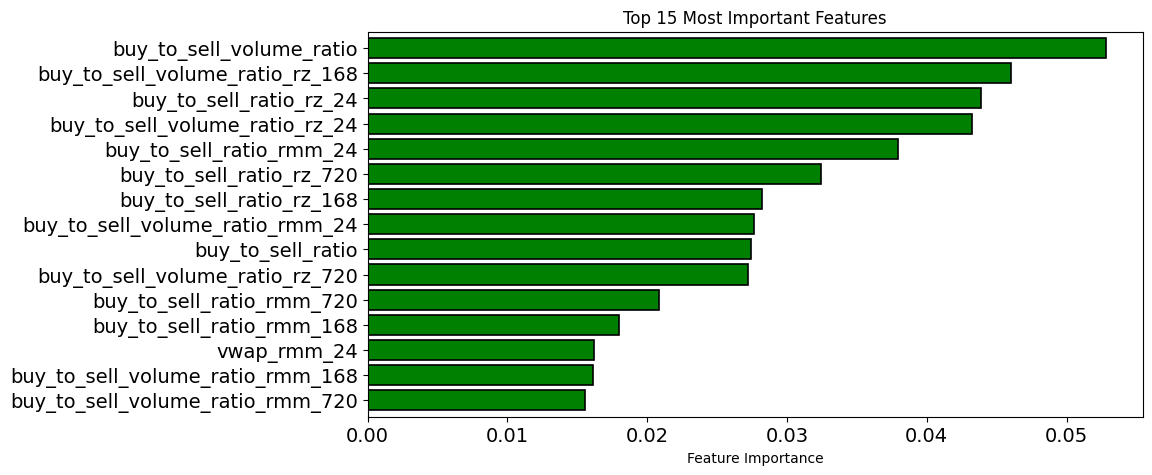

In [13]:
# Train Predictions
y_pred = best_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

# Classification report
print('Train Classification Report')
print()
print(classification_report(y_train, y_pred))

# Various metrics rounded to 4 decimal places
accuracy = round(accuracy_score(y_train, y_pred), 4)
precision = round(precision_score(y_train, y_pred, average = 'weighted'), 4)
recall = round(recall_score(y_train, y_pred, average = 'weighted'), 4)
f1 = round(f1_score(y_train, y_pred, average = 'weighted'), 4)
roc_auc = round(roc_auc_score(y_train, y_pred, average = 'weighted'), 4)

# Print various metrics
print('Train Accuracy: ', accuracy)
print('Train Precision: ', precision)
print('Train Recall: ', recall)
print('Train F1 Score: ', f1)
print('Train ROC AUC Score: ', roc_auc)

# Plot horizontal bar plot of top 15 most important features using Pandas
# w/ labels
feature_importances = pd.Series(best_model.feature_importances_, index = X_train.columns)
feature_importances.nlargest(15).sort_values().plot(
    kind = 'barh', 
    figsize = (10, 5), 
    title = 'Top 15 Most Important Features',
    color = 'green',
    xlabel = 'Feature Importance',
    fontsize = 14,
    width = 0.8,
    edgecolor = 'black',
    linewidth = 1.2
)
plt.show()


In [14]:
# Test predictions
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Classification report
print('Test Classification Report')
print()
print(classification_report(y_test, y_pred))

# Various metrics rounded to 4 decimal places
accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred, average = 'weighted'), 4)
recall = round(recall_score(y_test, y_pred, average = 'weighted'), 4)
f1 = round(f1_score(y_test, y_pred, average = 'weighted'), 4)
roc_auc = round(roc_auc_score(y_test, y_pred, average = 'weighted'), 4)

# Print various metrics
print('Test Accuracy: ', accuracy)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test F1 Score: ', f1)
print('Test ROC AUC Score: ', roc_auc)

Test Classification Report

              precision    recall  f1-score   support

        -1.0       0.70      0.47      0.57       480
         1.0       0.64      0.83      0.72       551

    accuracy                           0.66      1031
   macro avg       0.67      0.65      0.65      1031
weighted avg       0.67      0.66      0.65      1031

Test Accuracy:  0.6625
Test Precision:  0.6716
Test Recall:  0.6625
Test F1 Score:  0.6506
Test ROC AUC Score:  0.6504
